# Predicting and forecasting weather temperature with FBProphet

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

rcParams['figure.figsize'] = 22, 10
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

pd.set_option('max_columns', None)
pd.set_option('display.max_rows', 1000)

In [3]:
historical = pd.read_csv('data/cleaned_data.csv')

In [4]:
historical.dtypes

City                           object
State                          object
Wind Direction                float64
Latitude                      float64
Cloud Cover (%)               float64
Minimum Temperature (degF)    float64
Date time                      object
Precipitation (in)            float64
Dew Point (degF)              float64
Relative Humidity (%)         float64
Precipitation Cover (%)       float64
Longitude                     float64
Temperature (degF)            float64
Maximum Temperature (degF)    float64
Visibility (mi)               float64
Wind Speed (mph)              float64
Snow Depth (in)               float64
Sea Level Pressure (mb)       float64
Snow (in)                     float64
Wind Gust (mph)               float64
Conditions                     object
dtype: object

In [5]:
historical.head()

,City,State,Wind Direction,Latitude,Cloud Cover (%),Minimum Temperature (degF),Date time,Precipitation (in),Dew Point (degF),Relative Humidity (%),Precipitation Cover (%),Longitude,Temperature (degF),Maximum Temperature (degF),Visibility (mi),Wind Speed (mph),Snow Depth (in),Sea Level Pressure (mb),Snow (in),Wind Gust (mph),Conditions
0,Akron,OH,180.46,41.08431,10.3,23.2,2017-01-01,0.00,23.3,66.47,0.00,-81.51431,33.7,42.2,9.5,10.5,0.41,1020.8,0.00,26.420465,Clear
1,Akron,OH,84.79,41.08431,82.1,33.0,2017-01-02,0.00,37.6,85.22,16.67,-81.51431,41.8,47.8,3.4,7.3,0.00,1020.3,0.00,26.420465,Overcast
2,Akron,OH,179.42,41.08431,90.3,42.0,2017-01-03,0.37,43.6,90.06,66.67,-81.51431,46.3,48.8,5.0,13.1,0.00,1005.3,0.00,29.800000,"Rain, Overcast"
3,Akron,OH,275.25,41.08431,95.8,20.8,2017-01-04,0.02,20.8,68.33,20.83,-81.51431,30.2,43.0,8.6,31.5,0.00,1008.3,0.00,39.600000,"Rain, Overcast"
4,Akron,OH,257.54,41.08431,74.0,12.6,2017-01-05,0.02,10.7,71.11,37.50,-81.51431,18.5,20.8,5.2,15.1,1.02,1015.0,1.02,24.200000,"Snow, Partially cloudy"


In [6]:
historical.columns

Index(['City', 'State', 'Wind Direction', 'Latitude', 'Cloud Cover (%)',
       'Minimum Temperature (degF)', 'Date time', 'Precipitation (in)',
       'Dew Point (degF)', 'Relative Humidity (%)', 'Precipitation Cover (%)',
       'Longitude', 'Temperature (degF)', 'Maximum Temperature (degF)',
       'Visibility (mi)', 'Wind Speed (mph)', 'Snow Depth (in)',
       'Sea Level Pressure (mb)', 'Snow (in)', 'Wind Gust (mph)',
       'Conditions'],
      dtype='object')

In [7]:
# change target name for 'y' and date for 'ds' which is required for fbprophet
# other columns remain the same

df_final = historical[['City', 'State', 'Wind Direction', 'Latitude', 'Cloud Cover (%)',
       'Minimum Temperature (degF)', 'Date time', 'Precipitation (in)',
       'Dew Point (degF)', 'Relative Humidity (%)', 'Precipitation Cover (%)',
       'Longitude', 'Temperature (degF)', 'Maximum Temperature (degF)',
       'Visibility (mi)', 'Wind Speed (mph)', 'Snow Depth (in)',
       'Sea Level Pressure (mb)', 'Snow (in)', 'Wind Gust (mph)',
       'Conditions']].rename({'City': 'City', 'State': 'State', 'Wind Direction': 'Wind Direction', 'Latitude': 'Latitude', 'Cloud Cover (%)': 'Cloud Cover (%)',
       'Minimum Temperature (degF)': 'Minimum Temperature (degF)', 'Date time': 'ds', 'Precipitation (in)': 'Precipitation (in)',
       'Dew Point (degF)': 'Dew Point (degF)', 'Relative Humidity (%)': 'Relative Humidity (%)', 'Precipitation Cover (%)': 'Precipitation Cover (%)',
       'Longitude': 'Longitude', 'Temperature (degF)': 'y', 'Maximum Temperature (degF)': 'Maximum Temperature (degF)',
       'Visibility (mi)': 'Visibility (mi)', 'Wind Speed (mph)': 'Wind Speed (mph)', 'Snow Depth (in)': 'Snow Depth (in)',
       'Sea Level Pressure (mb)': 'Sea Level Pressure (mb)', 'Snow (in)': 'Snow (in)', 'Wind Gust (mph)': 'Wind Gust (mph)',
       'Conditions': 'Conditions'}, axis="columns")

In [8]:
# group cities
cities = df_final.groupby(['City','State'], as_index=False)

# train test split
train_prophet = pd.DataFrame()
test_prophet = pd.DataFrame()

# split data where 90% train 10% test per each city (train set 01/01/2017 - 10/13/2020, test set 10/14/2020 - 03/16/2021)
for city in cities.groups:
    group = cities.get_group(city)
    train_size = int(len(group) * 0.9)
    test_size = len(group) - train_size
    tr, ts = group.iloc[0:train_size], group.iloc[train_size:len(group)]
    train_prophet = pd.concat([train_prophet, tr])
    test_prophet = pd.concat([test_prophet, ts])

# train/test shape
train_prophet.shape, test_prophet.shape

((548653, 21), (61138, 21))

In [9]:
train_prophet.tail()

,City,State,Wind Direction,Latitude,Cloud Cover (%),Minimum Temperature (degF),ds,Precipitation (in),Dew Point (degF),Relative Humidity (%),Precipitation Cover (%),Longitude,y,Maximum Temperature (degF),Visibility (mi),Wind Speed (mph),Snow Depth (in),Sea Level Pressure (mb),Snow (in),Wind Gust (mph),Conditions
609632,Yuma,AZ,208.26,32.6855,2.3,68.0,2020-10-09,0.0,39.4,23.07,0.0,-114.625,83.5,96.2,8.1,12.7,0.0,1007.8,0.0,18.300000,Clear
609633,Yuma,AZ,148.05,32.6855,0.0,66.8,2020-10-10,0.0,46.9,33.94,0.0,-114.625,80.5,92.9,9.5,9.1,0.0,1009.0,0.0,25.093171,Clear
609634,Yuma,AZ,207.48,32.6855,0.0,68.0,2020-10-11,0.0,46.7,32.77,0.0,-114.625,81.3,93.8,9.9,9.2,0.0,1010.2,0.0,25.093171,Clear
609635,Yuma,AZ,100.00,32.6855,0.0,70.1,2020-10-12,0.0,40.1,23.75,0.0,-114.625,83.8,99.0,9.9,9.2,0.0,1012.2,0.0,25.093171,Clear
609636,Yuma,AZ,115.83,32.6855,0.0,71.0,2020-10-13,0.0,35.0,19.21,0.0,-114.625,85.8,104.0,7.8,11.4,0.0,1012.5,0.0,25.093171,Clear


### Train fbprophet

In [10]:
%%timeit -n1 -r1

# group cities for train set
tr_prophet = train_prophet.groupby(['City','State'], as_index=False)

# forecast per each city
for city in tr_prophet.groups:
    group = tr_prophet.get_group(city)
    
    # define model 
    m = Prophet()
    
    # fit the data
    m.fit(group)
    
    # make forecast for next two years
    future = m.make_future_dataframe(periods=365*2, freq='D')
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast['City'] = city[0]
    forecast['State'] = city[1]
    
    # append csv with forecasted data
    forecast.to_csv('data/weather_forecast.csv', mode='a', index='False')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

1 loop, best of 1: 52min 17s per loop


In [11]:
# read forecast
forecast = pd.read_csv('data/weather_forecast.csv', index_col=0)

In [12]:
# remove appended headers
forecast = forecast[~(forecast['City'] == 'City')]

In [13]:
# convert date column to datetime type 
train_prophet['ds'] = pd.to_datetime(train_prophet['ds'], infer_datetime_format=True)
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'], infer_datetime_format=True)
forecast['ds'] = pd.to_datetime(forecast['ds'], infer_datetime_format=True)

In [14]:
# set datetime as index
train_prophet = train_prophet.set_index('ds')
test_prophet = test_prophet.set_index('ds')
forecast = forecast.set_index('ds')

In [15]:
# convert number strings to floats
forecast[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']].astype(float)

### Visualize a few cities forecast and compare with true values

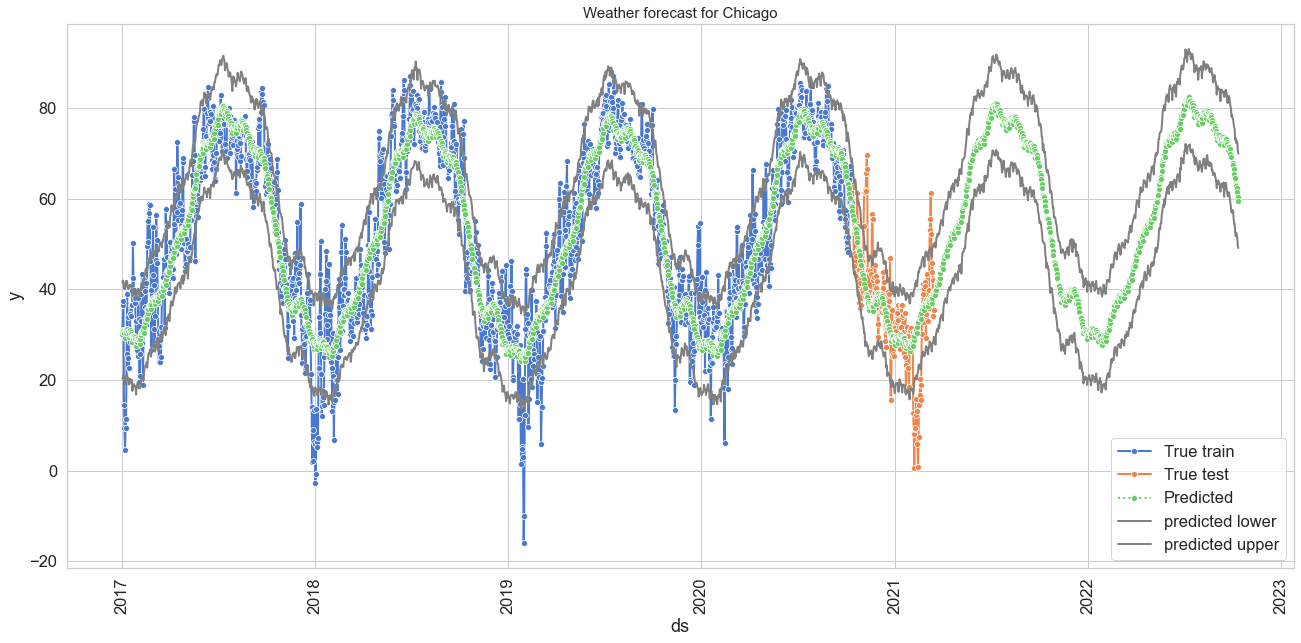

In [18]:
chicago_h = train_prophet[train_prophet['City'] == 'Chicago']
chicago_h_t = test_prophet[test_prophet['City'] == 'Chicago']

chicago_f = forecast[forecast['City'] == 'Chicago']

sns.lineplot(x=chicago_h.index, y='y', data=chicago_h,  marker='o', linewidth=2, label='True train')
sns.lineplot(x=chicago_h_t.index, y='y', data=chicago_h_t, linewidth=2, marker='o', label='True test')
sns.lineplot(x=chicago_f.index, y='yhat', data=chicago_f, linewidth=2, linestyle=':', marker='o', ci='int', label='Predicted')
sns.lineplot(x=chicago_f.index, y='yhat_lower', data=chicago_f, linewidth=2, linestyle='-', color='gray', label='predicted lower')
sns.lineplot(x=chicago_f.index, y='yhat_upper', data=chicago_f, linewidth=2, linestyle='-', color='gray', label='predicted upper')

plt.title("Weather forecast for Chicago",fontsize=15)
plt.legend()
plt.xticks(rotation = 'vertical')
plt.show()

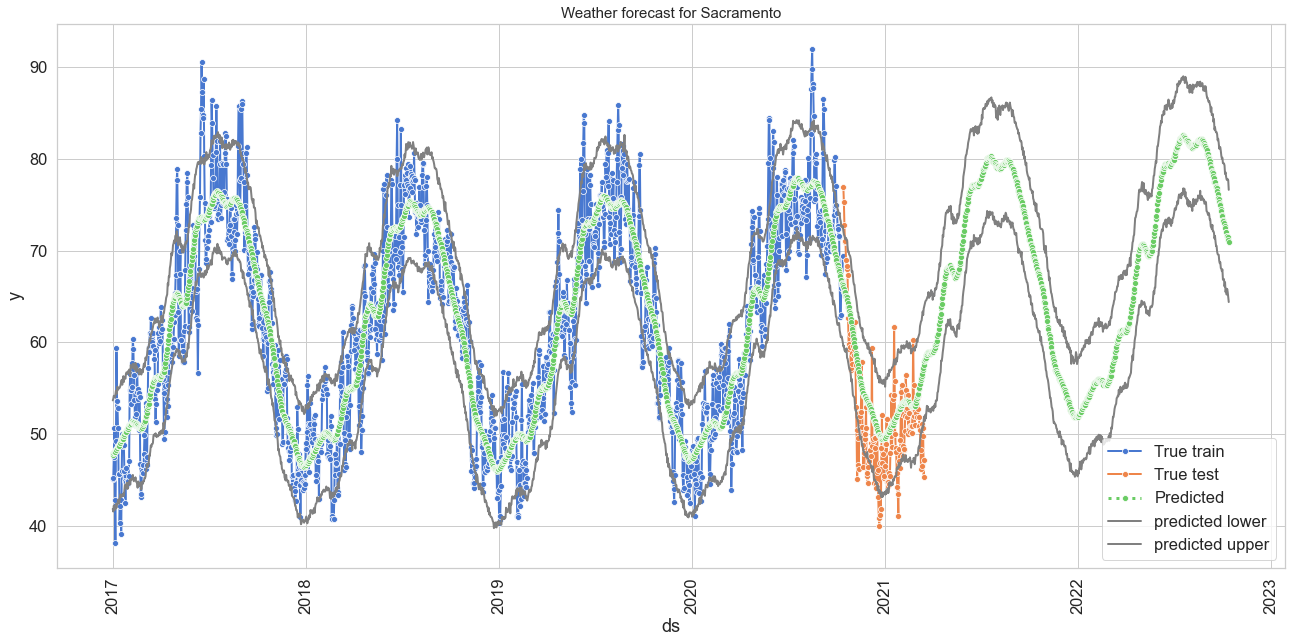

In [19]:
sacramento_h = train_prophet[train_prophet['City'] == 'Sacramento']
sacramento_h_t = test_prophet[test_prophet['City'] == 'Sacramento']
sacramento_f = forecast[forecast['City'] == 'Sacramento']

sns.lineplot(x=sacramento_h.index, y='y', data=sacramento_h,  marker='o', linewidth=2, label='True train')
sns.lineplot(x=sacramento_h_t.index, y='y', data=sacramento_h_t, linewidth=2, marker='o',  label='True test')
sns.lineplot(x=sacramento_f.index, y='yhat', data=sacramento_f, linewidth=3, linestyle=':', marker='o',  label='Predicted')
sns.lineplot(x=sacramento_f.index, y='yhat_lower', data=sacramento_f, linewidth=2, linestyle='-', color='gray', label='predicted lower')
sns.lineplot(x=sacramento_f.index, y='yhat_upper', data=sacramento_f, linewidth=2, linestyle='-', color='gray', label='predicted upper')

plt.title("Weather forecast for Sacramento",fontsize=15)

plt.xticks(rotation = 'vertical')
plt.show()

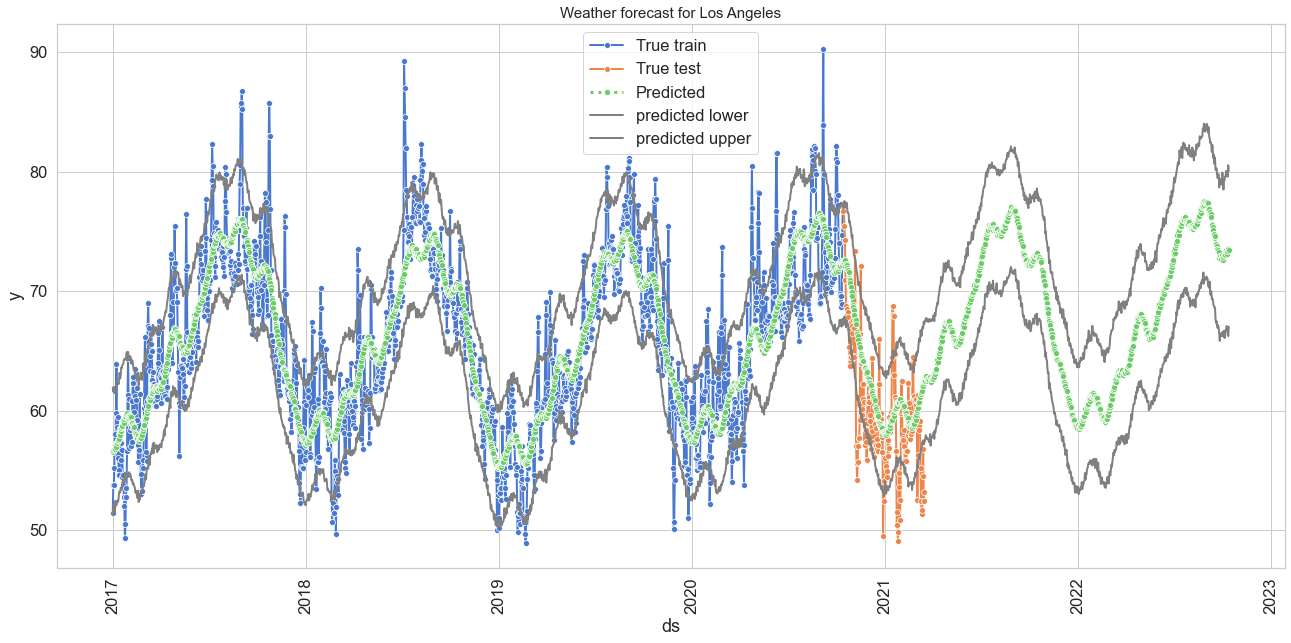

In [20]:
la_h = train_prophet[train_prophet['City'] == 'Los Angeles']
la_h_t = test_prophet[test_prophet['City'] == 'Los Angeles']
la_f = forecast[forecast['City'] == 'Los Angeles']

sns.lineplot(x=la_h.index, y='y', data=la_h,  marker='o', linewidth=2, label='True train')
sns.lineplot(x=la_h_t.index, y='y', data=la_h_t, linewidth=2, marker='o', label='True test')
sns.lineplot(x=la_f.index, y='yhat', data=la_f, linewidth=3, linestyle=':', marker='o', label='Predicted')
sns.lineplot(x=la_f.index, y='yhat_lower', data=la_f, linewidth=2, linestyle='-', color='gray', label='predicted lower')
sns.lineplot(x=la_f.index, y='yhat_upper', data=la_f, linewidth=2, linestyle='-', color='gray', label='predicted upper')

plt.title("Weather forecast for Los Angeles",fontsize=15)

plt.xticks(rotation = 'vertical')
plt.show()

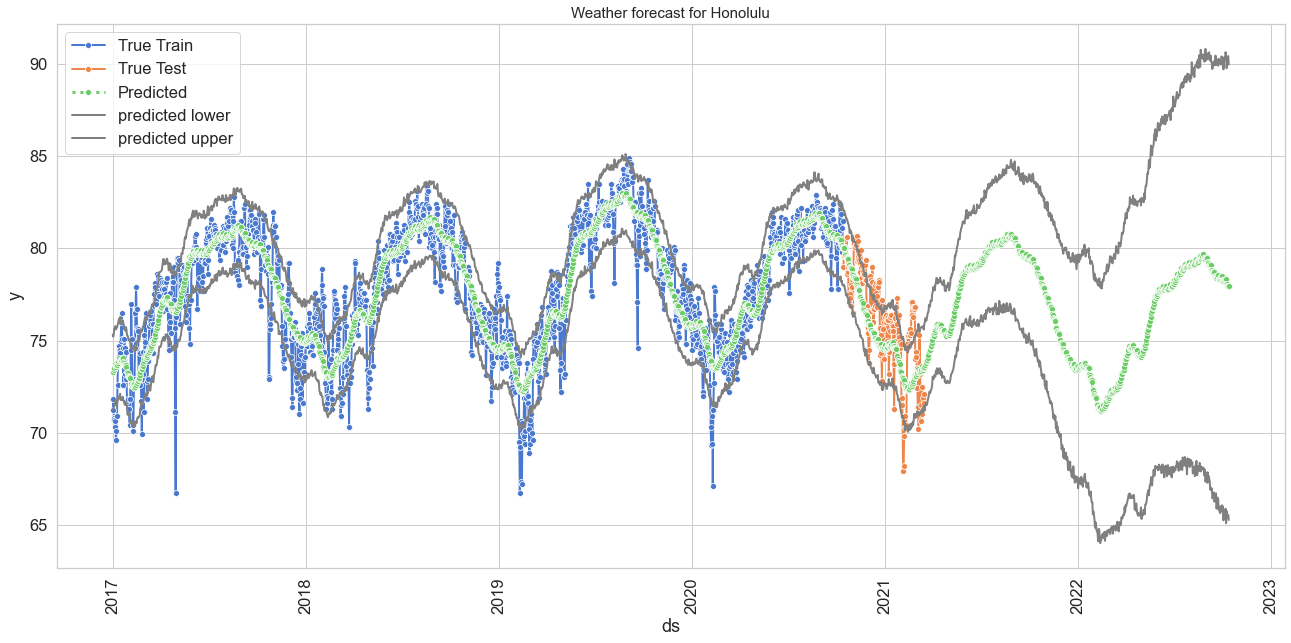

In [21]:
honolulu_h = train_prophet[train_prophet['City'] == 'Honolulu']
honolulu_h_t = test_prophet[test_prophet['City'] == 'Honolulu']
honolulu_f = forecast[forecast['City'] == 'Honolulu']

sns.lineplot(x=honolulu_h.index, y='y', data=honolulu_h,  marker='o', linewidth=2, label='True Train')
sns.lineplot(x=honolulu_h_t.index, y='y', data=honolulu_h_t, linewidth=2, marker='o', label='True Test')
sns.lineplot(x=honolulu_f.index, y='yhat', data=honolulu_f, linewidth=3, linestyle=':', marker='o', label='Predicted')
sns.lineplot(x=honolulu_f.index, y='yhat_lower', data=honolulu_f, linewidth=2, linestyle='-', color='gray', label='predicted lower')
sns.lineplot(x=honolulu_f.index, y='yhat_upper', data=honolulu_f, linewidth=2, linestyle='-', color='gray', label='predicted upper')

plt.title("Weather forecast for Honolulu",fontsize=15)

plt.xticks(rotation = 'vertical')
plt.show()

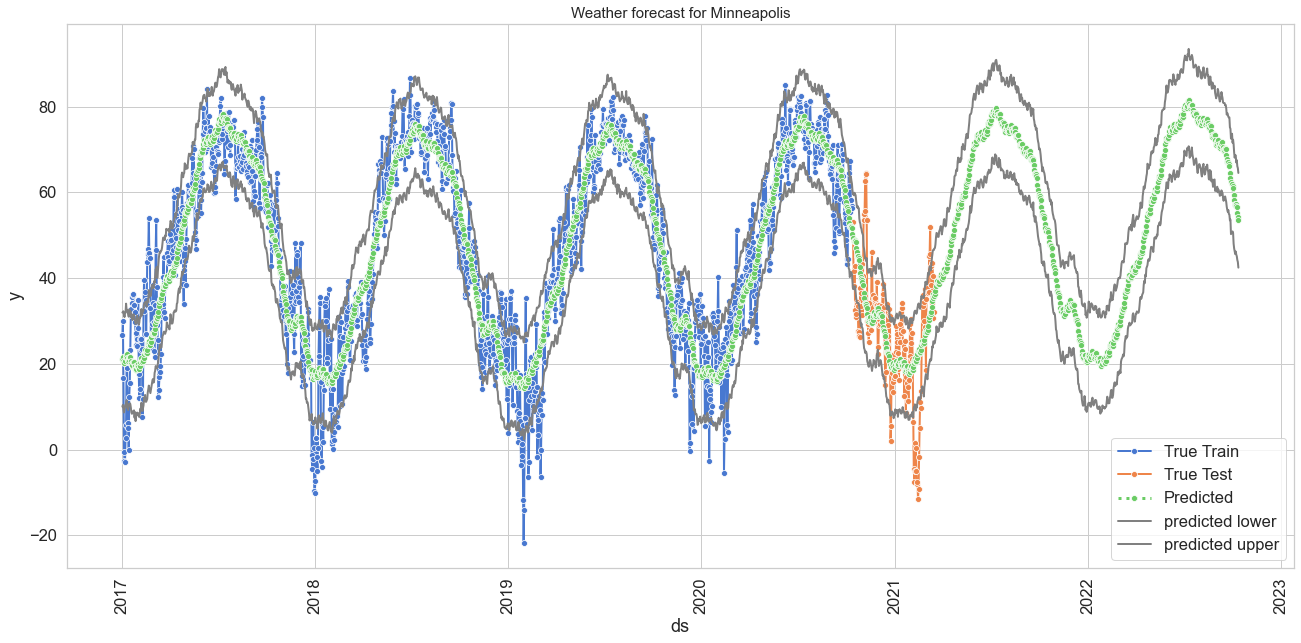

In [22]:
minneapolis_h = train_prophet[train_prophet['City'] == 'Minneapolis']
minneapolis_h_t = test_prophet[test_prophet['City'] == 'Minneapolis']
minneapolis_f = forecast[forecast['City'] == 'Minneapolis']

sns.lineplot(x=minneapolis_h.index, y='y', data=minneapolis_h,  marker='o', linewidth=2, label='True Train')
sns.lineplot(x=minneapolis_h_t.index, y='y', data=minneapolis_h_t, linewidth=2, marker='o', label='True Test')
sns.lineplot(x=minneapolis_f.index, y='yhat', data=minneapolis_f, linewidth=3, linestyle=':', marker='o', label='Predicted')
sns.lineplot(x=minneapolis_f.index, y='yhat_lower', data=minneapolis_f, linewidth=2, linestyle='-', color='gray', label='predicted lower')
sns.lineplot(x=minneapolis_f.index, y='yhat_upper', data=minneapolis_f, linewidth=2, linestyle='-', color='gray', label='predicted upper')

plt.title("Weather forecast for Minneapolis",fontsize=15)

plt.xticks(rotation = 'vertical')
plt.show()

In [23]:
# Check performance metrics Mean Absolute Error and Mean Square Root Error for test set
mae = mean_absolute_error(sacramento_h_t['y'], sacramento_f[(sacramento_f.index >= '10-14-2020') & (sacramento_f.index <= '03-16-2021')]['yhat'])
msre = np.sqrt(mean_squared_error(sacramento_h_t['y'], sacramento_f[(sacramento_f.index >= '10-14-2020') & (sacramento_f.index <= '03-16-2021')]['yhat']))

print("Sacramento:")
print("MAE",mae)
print("MSRE",msre)

Sacramento:
MAE 4.349197150067481
MSRE 5.2263055788897335


In [24]:
mae = mean_absolute_error(honolulu_h_t['y'], honolulu_f[(honolulu_f.index >= '10-14-2020') & (honolulu_f.index <= '03-16-2021')]['yhat'])
msre = np.sqrt(mean_squared_error(honolulu_h_t['y'], honolulu_f[(honolulu_f.index >= '10-14-2020') & (honolulu_f.index <= '03-16-2021')]['yhat']))

print('Honolulu:')
print("MAE",mae)
print("MSRE",msre)

Honolulu:
MAE 1.7690075840187391
MSRE 2.05375674046355


In [28]:
mae = mean_absolute_error(minneapolis_h_t['y'], minneapolis_f[(minneapolis_f.index >= '10-14-2020') & (minneapolis_f.index <= '03-16-2021')]['yhat'])
msre = np.sqrt(mean_squared_error(minneapolis_h_t['y'], minneapolis_f[(minneapolis_f.index >= '10-14-2020') & (minneapolis_f.index <= '03-16-2021')]['yhat']))

print('Minneapolis:')
print("MAE",mae)
print("MSRE",msre)

Minneapolis:
MAE 9.030289544060139
MSRE 11.963451244403847


In [26]:
mae = mean_absolute_error(la_h_t['y'], la_f[(la_f.index >= '10-14-2020') & (la_f.index <= '03-16-2021')]['yhat'])
msre = np.sqrt(mean_squared_error(la_h_t['y'], la_f[(la_f.index >= '10-14-2020') & (la_f.index <= '03-16-2021')]['yhat']))

print('Los Angeles:')
print("MAE",mae)
print("MSRE",msre)

Los Angeles:
MAE 3.938620692032072
MSRE 4.952466401625835


In [29]:
mae = mean_absolute_error(chicago_h_t['y'], chicago_f[(chicago_f.index >= '10-14-2020') & (chicago_f.index <= '03-16-2021')]['yhat'])
msre = np.sqrt(mean_squared_error(chicago_h_t['y'], chicago_f[(chicago_f.index >= '10-14-2020') & (chicago_f.index <= '03-16-2021')]['yhat']))

print('Chicago:')
print("MAE",mae)
print("MSRE",msre)

Chicago:
MAE 7.6597258170358895
MSRE 10.620082958886316


# fbprophet can predict weather trends but can't catch extreme values 

# use all data for forecasting

In [ ]:
%%timeit -n1 -r1

# group cities for al data
cities = df_final.groupby(['City','State'], as_index=False)

# forecast per each city
for city in cities.groups:
    group = cities.get_group(city)
    
    # define model 
    m = Prophet()
    
    # fit the data
    m.fit(group)
    
    # make forecast for next two years
    future = m.make_future_dataframe(periods=365*2, freq='D')
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast['City'] = city[0]
    forecast['State'] = city[1]
    
    # append csv with forecasted data
    forecast.to_csv('data/weather_2year_forecast.csv', mode='a', index='False')